In [23]:
!pip install numpy pandas scikit-learn pillow torch torchvision open-clip-torch timm ultralytics deep-sort-realtime tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import shutil
from datetime import datetime, timedelta

import numpy as np
from PIL import Image
import torch
from tqdm.auto import tqdm

import open_clip
from ultralytics import YOLO
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import timm -> per il ViT


from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, leaves_list


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Definizione di costanti, modello e funzioni di utilità

In [ ]:
PATH_IMAGES = "Home Assistant Monitor Complete Jul 5 2025/images"
OUTPUT_DIR = "clusters_triplet"

yolo_model = YOLO('yolov8l.pt')
yolo_model = yolo_model.to(device).eval()

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model = clip_model.to(device).eval()

# ViT - in questa versione non usato ma si può considerarne la integrazione futura
# vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
# vit = vit.to(device).eval()

In [ ]:
def expand_bbox(bbox, img_w, img_h, expansion_ratio=0.3):
    xmin, ymin, xmax, ymax = bbox
    w, h = xmax - xmin, ymax - ymin
    pad_w, pad_h = w * expansion_ratio, h * expansion_ratio
    xmin_e = max(int(xmin - pad_w), 0)
    ymin_e = max(int(ymin - pad_h), 0)
    xmax_e = min(int(xmax + pad_w), img_w - 1)
    ymax_e = min(int(ymax + pad_h), img_h - 1)
    return xmin_e, ymin_e, xmax_e, ymax_e


def extract_clip_embedding(image):
    img_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = clip_model.encode_image(img_tensor)
        feat = feat / feat.norm(dim=-1, keepdim=True)
    return feat.squeeze().cpu().numpy()

"""

def extract_scene_embedding(image_path):
    pil_img = Image.open(image_path).convert("RGB")
    pil_img = pil_img.resize((224, 224), Image.LANCZOS)
    img_tensor = torch.from_numpy(np.array(pil_img)).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    
    with torch.no_grad():
        features = vit(img_tensor)  # 768 dimensioni
    
    return features.squeeze().cpu().numpy()
    
"""

### Processing e lettura delle immagini

Inanìzitutto si costruisce una lista con tutte le immagini da analizzare, successivamente per ogni immagine si isolano le persone, riconoscendole con yolo e tagliandole, e si calcola l'embedding.

In [ ]:
image_info = []
for root, _, files in os.walk(PATH_IMAGES):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                ts = os.path.splitext(file)[0]
                dt = datetime.strptime(ts, "%d-%m_%H-%M-%S")
                image_info.append((dt, os.path.join(root, file)))
            except ValueError:
                continue
image_info.sort()

all_image_paths = [p for _, p in image_info]

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

import pickle

def process_image(img_path):
    pil_img = Image.open(img_path).convert("RGB")
    w, h = pil_img.size
    mid_x = w // 2

    left_img = pil_img.crop((0, 0, mid_x, h))
    right_img = pil_img.crop((mid_x, 0, w, h))

    results_all = []

    results_left = yolo_model(left_img, verbose=False)[0]
    for bbox, cls, conf in zip(results_left.boxes.xyxy.cpu().numpy(), results_left.boxes.cls.cpu().numpy(), results_left.boxes.conf.cpu().numpy()):
        if int(cls) == 0 and conf >= 0.1:
            xmin, ymin, xmax, ymax = bbox
            results_all.append([xmin, ymin, xmax, ymax, conf])

    results_right = yolo_model(right_img, verbose=False)[0]
    for bbox, cls, conf in zip(results_right.boxes.xyxy.cpu().numpy(), results_right.boxes.cls.cpu().numpy(), results_right.boxes.conf.cpu().numpy()):
        if int(cls) == 0 and conf >= 0.1:
            xmin, ymin, xmax, ymax = bbox
            xmin += mid_x
            xmax += mid_x
            results_all.append([xmin, ymin, xmax, ymax, conf])

    dets = []
    for xmin, ymin, xmax, ymax, conf in results_all:
        if xmax <= xmin or ymax <= ymin:
            continue

        crop = pil_img.crop((
            max(0, xmin - 0.15 * (xmax - xmin)),
            max(0, ymin - 0.15 * (ymax - ymin)),
            min(pil_img.width, xmax + 0.15 * (xmax - xmin)),
            min(pil_img.height, ymax + 0.15 * (ymax - ymin))
        ))

        if crop.width == 0 or crop.height == 0:
            continue

        emb = extract_clip_embedding(crop)

        dets.append({
            "original": None,
            "crop": None,
            "bbox": [xmin, ymin, xmax, ymax],
            "embedding": emb,
        })

    return img_path, dets


person_detections_per_image = dict()


# da provare senza multi thread causa mps

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_image, img_path) for img_path in all_image_paths]
    with tqdm(total=len(futures), desc="Processing images") as pbar:
        for future in as_completed(futures):
            img_path, dets = future.result()
            person_detections_per_image[img_path] = dets
            pbar.update(1)

to_save = dict()
for key in person_detections_per_image:
    values = person_detections_per_image[key]
    to_save[key] = values.copy()
    for val in to_save[key]:
        val["crop"] = None
        val["original"] = None

with open("person_detections_per_image.pkl", "wb") as f:
    pickle.dump(to_save, f)

Processing images: 100%|██████████| 33243/33243 [2:10:57<00:00,  4.23it/s]  


### STEP 1: divido in cluster le diverse pose / situazioni delle persone

In questa fase ogni persona viene considerataa a se, si ragruppano le pose per una fase successiva

In [37]:
features = []

for i, key in tqdm(enumerate(person_detections_per_image), total=len(person_detections_per_image)):
    values = person_detections_per_image[key]
    values_sorted = sorted(
        values,
        key=lambda v: (v["bbox"][2] - v["bbox"][0]) * (v["bbox"][3] - v["bbox"][1]),
        reverse=True 
    )

    if not values_sorted:
        features.append([0] * 512)
        continue

    for val in values_sorted:
        features.append(val["embedding"])
        val["feature index"] = len(features) - 1    
        val["path"] = all_image_paths[i]


features = np.array(features)

features.shape

100%|██████████| 33243/33243 [00:00<00:00, 294353.12it/s]


(37775, 512)

In [31]:
features_std = StandardScaler().fit_transform(features)
pca = PCA(n_components=min(features.shape[0], 20), random_state=42)
features_pca = pca.fit_transform(features_std)

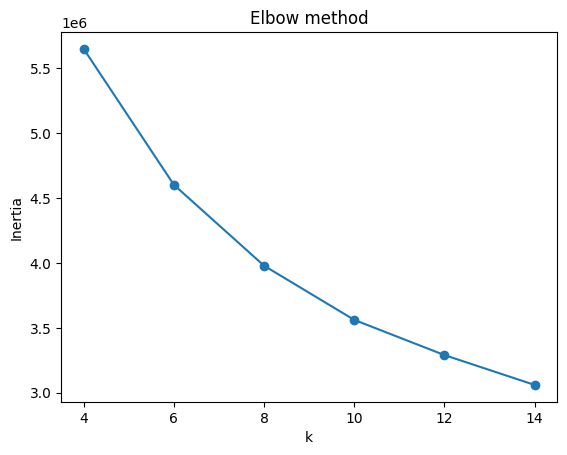

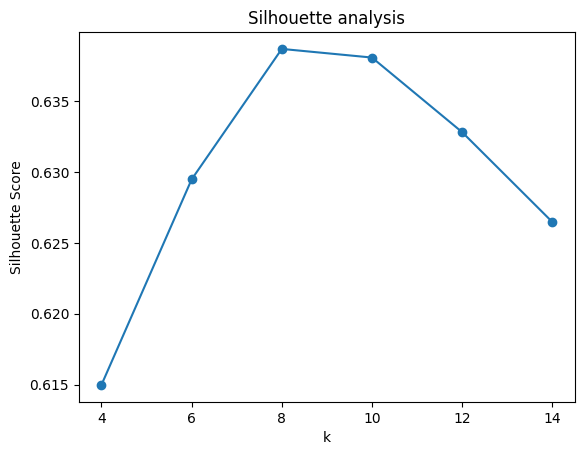

In [34]:
inertias = []
K_range = range(4, 16, 2)
silhouette_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(features_pca)
    inertias.append(km.inertia_)

    labels_tmp = km.labels_
    n_labels = len(set(labels_tmp))

    if n_labels > 1 and n_labels < len(features_pca):
        score = silhouette_score(features_pca, labels_tmp)
    else:
        score = float('nan')
    silhouette_scores.append(score)

plt.plot(K_range, inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

plt.plot(K_range, silhouette_scores, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis')
plt.show()

In [ ]:

k = 500 
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_persons = kmeans.fit_predict(features_pca)

centroids = kmeans.cluster_centers_
dists = cdist(centroids, centroids)

linkage_matrix = linkage(centroids, method='ward')
ordered_cluster_ids = leaves_list(linkage_matrix) 

label_map = {old: new for new, old in enumerate(ordered_cluster_ids)}
labels_persons = np.array([label_map[label] for label in labels_persons])


In [48]:
from collections import defaultdict

output_dir = "clusters_kmeans_500"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

index_to_cluster = {i: label for i, label in enumerate(labels_persons)}

clusters = defaultdict(list)

for key, values in person_detections_per_image.items():
    for val in values:
        cluster_id = index_to_cluster.get(val["feature index"])
        if cluster_id is not None:
            clusters[cluster_id].append((val, key))

for cluster_id, items in tqdm(clusters.items(), desc="Saving clusters"):
    cluster_folder = os.path.join(output_dir, f"cluster_{cluster_id}")
    os.makedirs(cluster_folder, exist_ok=True)

    for idx, (val, key) in enumerate(items):
        img = Image.open(val["path"])
        xmin, ymin, xmax, ymax = val["bbox"]
        crop = img.crop((
            max(0, xmin - 0.15 * (xmax - xmin)),
            max(0, ymin - 0.15 * (ymax - ymin)),
            min(img.width, xmax + 0.15 * (xmax - xmin)),
            min(img.height, ymax + 0.15 * (ymax - ymin))
        ))

        filename = os.path.basename(val["path"]).replace(".jpg", "") + f"_{idx}.jpg"
        crop.save(os.path.join(cluster_folder, filename))

Saving clusters: 100%|██████████| 499/499 [01:15<00:00,  6.58it/s]


*vanno puliti tramite server_normal.js questi risultati*

### STEP 2: sfruttando i cluster creati in precedenza divido le immagini per attività che stannno facendo le persone

- Aver ordinato correttamente i cluster precedenti in base alla somiglianza tra loro mi permette ora di usare l'algoritmo di Kmeans al posto di quello, meno efficiente, di KModes.
- Questo mi permette di avere le immagini originali divise in cluster

In [66]:
features = []
img_path_feature = []


n_max_detections = max([len(v) for v in person_detections_per_image.values()])
BASE_LISTS_PERSONS = [-1 for _ in range(n_max_detections) ]

for key in tqdm(person_detections_per_image):
    values = person_detections_per_image[key]
    values_sorted = sorted(
        values,
        key=lambda v: (v["bbox"][2] - v["bbox"][0]) * (v["bbox"][3] - v["bbox"][1]),
        reverse=True 
    )

    list_ = BASE_LISTS_PERSONS.copy()
    for i, v in enumerate(values_sorted):
        if i < len(list_): list_[i] = v["feature index"]

    features.append(np.array(list_))
    img_path_feature.append(key)

features = np.array(features)

features.shape

100%|██████████| 33243/33243 [00:00<00:00, 556396.32it/s]


(33243, 6)

In [52]:
features_std = StandardScaler().fit_transform(features)
pca = PCA(n_components=min(features.shape[0], 20, features.shape[1]), random_state=42)
features_pca = pca.fit_transform(features_std)

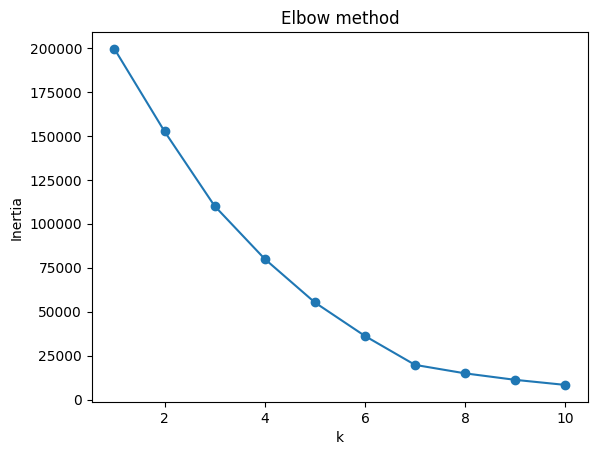

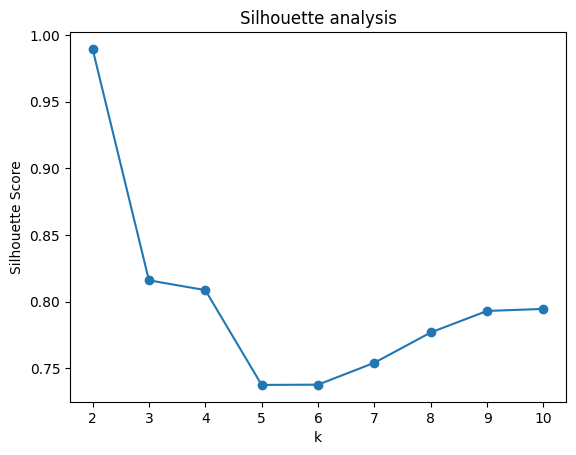

In [56]:
inertias = []
K_range = range(1, 11, 1)
silhouette_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(features_pca)
    inertias.append(km.inertia_)

    labels_tmp = km.labels_
    n_labels = len(set(labels_tmp))

    if n_labels > 1 and n_labels < len(features_pca):
        score = silhouette_score(features_pca, labels_tmp)
    else:
        score = float('nan')
    silhouette_scores.append(score)

plt.plot(K_range, inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

plt.plot(K_range, silhouette_scores, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis')
plt.show()

In [69]:
k = 500 
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_multi_persons = kmeans.fit_predict(features_pca)

centroids = kmeans.cluster_centers_
dists = cdist(centroids, centroids)

linkage_matrix = linkage(centroids, method='ward')
ordered_cluster_ids = leaves_list(linkage_matrix) 

label_map = {old: new for new, old in enumerate(ordered_cluster_ids)}
labels_multi_persons = np.array([label_map[label] for label in labels_multi_persons])

In [70]:
output_dir = "clusters_kmeans_500_multi"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)

for i, label in enumerate(labels_multi_persons):
    cluster_folder = os.path.join(output_dir, f"cluster_{label}")
    os.makedirs(cluster_folder, exist_ok=True)
    shutil.copy(img_path_feature[i], os.path.join(cluster_folder, os.path.basename(img_path_feature[i])))

*vanno puliti tramite server_normal.js questi risultati*

### STEP 3: divido in cluster i gruppetti in immagini di 3 in 3, inoltre aggiungo altre feature

Ottengo gruppi di 3 immagini ragruppate secondo i cluster calcolati nel punto 2 e le featurre aggiuntive che si trovano nel csv

In [73]:
import pandas as pd

csv = pd.read_csv("Home Assistant Monitor Complete Jul 5 2025/stati_home_assistant.csv")

csv['timestamp'] = pd.to_datetime(csv['timestamp'])

def parse_image_timestamp(path):
    filename = path.split("/")[-1].replace(".jpg", "")
    dt = datetime.strptime(filename, "%d-%m_%H-%M-%S")
    dt = dt.replace(year=2025)
    return dt

info_dict = {}

for path in all_image_paths:
    image_time = parse_image_timestamp(path)
    csv['delta'] = (csv['timestamp'] - image_time).abs()
    candidates = csv[csv['delta'] <= timedelta(milliseconds=750)]

    if not candidates.empty:
        closest_row = candidates.sort_values('delta').iloc[0]
        info_dict[path] = closest_row.drop('delta').to_dict()
    else:
        info_dict[path] = None


In [75]:
from sklearn.preprocessing import LabelEncoder

keys = list(next(v for v in info_dict.values() if v is not None).keys())
encoders = {k: LabelEncoder() for k in keys if k != 'timestamp'}

for k in encoders:
    values = [info[k] for info in info_dict.values() if info is not None]
    encoders[k].fit(values)

In [88]:
from bisect import bisect_left

def extract_temporal_features(timestamp):
    hour = timestamp.hour
    weekday = timestamp.weekday()

    month = timestamp.month
    if month in [12, 1, 2]:
        season = 0  # inverno
    elif month in [3, 4, 5]:
        season = 1  # primavera
    elif month in [6, 7, 8]:
        season = 2  # estate
    else:
        season = 3  # autunno

    return hour, weekday, season

timestamps = [dt for dt, _ in image_info]
paths = all_image_paths

grouped_triplets = []
tolerance = timedelta(seconds=30)
for i in range(2, len(timestamps)):
    t0 = timestamps[i]
    t1, t2 = t0 - timedelta(minutes=1), t0 - timedelta(minutes=2)

    idx1 = max(0, bisect_left(timestamps, t1) - 1)
    while idx1 > 0 and abs(timestamps[idx1] - t1) > abs(timestamps[idx1 - 1] - t1):
        idx1 -= 1
    idx2 = max(0, bisect_left(timestamps, t2) - 1)
    while idx2 > 0 and abs(timestamps[idx2] - t2) > abs(timestamps[idx2 - 1] - t2):
        idx2 -= 1
    if abs(timestamps[idx1] - t1) <= tolerance and abs(timestamps[idx2] - t2) <= tolerance:
        grouped_triplets.append([paths[idx2], paths[idx1], paths[i]])

scene_histograms = []
scene_groups = []

for group in tqdm(grouped_triplets, desc="Building histograms"):
    hist = []
    for img_path in group:
        # scene_emb = extract_scene_embedding(img_path) # provare a creare i cluster anche senza scene embedding, siamo più concentrati sulle persone
        img_idx = img_path_feature.index(img_path) if img_path in img_path_feature else -1
        person_cluster_label = labels_multi_persons[img_idx] if img_idx >= 0 else -1
        num_persons = len(person_detections_per_image.get(img_path, []))
        # combined_features = np.concatenate([
        #     scene_emb,                    # 7 dimensioni68
        #     [person_cluster_label]*20,       # 20 dimensione  
        #     [num_persons]*20                 # 20 dimensione
        # ])

        feature_list = [person_cluster_label, num_persons] * 5
        csv_info = info_dict.get(img_path)


        if csv_info is not None:
            ts = pd.to_datetime(csv_info['timestamp'])
            hour, weekday, season = extract_temporal_features(ts)
            feature_list.extend([hour, weekday])

            for k in keys:
                if k in ["timestamp", "light.lampada" ,"light.letto","light.scrivania","switch.monitor", "delta", "sensor.luminosita_camera"]:
                    continue
                v = csv_info[k]
                if k in encoders:
                    encoded_val = encoders[k].transform([v])[0]
                    feature_list.append(encoded_val)
                else:
                    feature_list.append(float(v))
        else:
            break

        combined_features = np.array(feature_list)


        hist.append(combined_features)
        
        # embedding della immagine -> vedere come farlo, forse non con open clipt ma con qualcosa di più generico
        # passare anche come dati le informazini sui cluster per le persone nell'immagine

    if len(hist) != 3:
        continue
        
    scene_histograms.append(np.concatenate(hist))
    scene_groups.append(group)

Building histograms: 100%|██████████| 32871/32871 [00:48<00:00, 681.72it/s] 


In [97]:
H = np.stack(scene_histograms)
print(H.shape)

scaler = StandardScaler()
H_scaled = scaler.fit_transform(H)

pca = PCA(n_components=20, random_state=42)
H_pca = pca.fit_transform(H_scaled)

(31069, 39)


In [ ]:
K_range_scenes = range(10, 201, 5)  # es. [10,20,...,100]
inertias_scenes = []
silhouette_scenes = []

for k in K_range_scenes:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(H_pca)
    inertias_scenes.append(km.inertia_)
    if k > 1 and k < len(H_pca):
        labels_s = km.labels_
        silhouette_scenes.append(silhouette_score(H_pca, labels_s))
    else:
        silhouette_scenes.append(np.nan)

# Plot Elbow per livello 2
plt.figure()
plt.plot(list(K_range_scenes), inertias_scenes, 'o-')
plt.xlabel('k (scene clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method — Level 2')
plt.show()

# Plot Silhouette per livello 2
plt.figure()
plt.plot(list(K_range_scenes), silhouette_scenes, 'o-')
plt.xlabel('k (scene clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis — Level 2')
plt.show()

In [99]:
k = 500 
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_scenes = kmeans.fit_predict(features_pca)

centroids = kmeans.cluster_centers_
dists = cdist(centroids, centroids)

linkage_matrix = linkage(centroids, method='ward')
ordered_cluster_ids = leaves_list(linkage_matrix) 

label_map = {old: new for new, old in enumerate(ordered_cluster_ids)}
labels_scenes = np.array([label_map[label] for label in labels_scenes])


In [ ]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

for idx, (group, lbl) in tqdm(enumerate(zip(scene_groups, labels_scenes)), total=len(scene_groups)):
    out_dir = os.path.join(OUTPUT_DIR, f"cluster_{lbl}", f"group_{idx}")
    os.makedirs(out_dir, exist_ok=True)
    for img in group:
        shutil.copy(img, os.path.join(out_dir, os.path.basename(img)))
